In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt
import bempp.api.shapes.fractals

In [2]:
menger_sponge1 = bempp.api.shapes.fractals.menger_sponge(h = 0.1, level = 0)
vertices_menger_sponge1 = menger_sponge1.vertices
elements_menger_sponge1 = menger_sponge1.elements

In [3]:
space_menger_sponge1 = bempp.api.function_space(menger_sponge1,'P',1)

In [120]:
dist = 0.5

In [121]:
vertices_menger_sponge2 = np.zeros((vertices_menger_sponge1.shape[0], vertices_menger_sponge1.shape[1]))
for i in range(vertices_menger_sponge1.shape[0]):
    for j in range(vertices_menger_sponge1.shape[1]):
        if i != 1:
            vertices_menger_sponge2[i,j] = vertices_menger_sponge1[i,j]
        else:
            vertices_menger_sponge2[i,j] = vertices_menger_sponge1[i,j] + 1 + dist
elements_menger_sponge2 = elements_menger_sponge1
menger_sponge2 = bempp.api.Grid(vertices_menger_sponge2, elements_menger_sponge2)
space_menger_sponge2 = bempp.api.function_space(menger_sponge2,'P',1)

In [93]:
results = []
for num in np.arange(1, 25+1, 1):

    wavenumber = 1j * num

    slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_menger_sponge1, space_menger_sponge1, space_menger_sponge1, wavenumber)
    slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_menger_sponge2, space_menger_sponge1, space_menger_sponge1, wavenumber)
    slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_menger_sponge1, space_menger_sponge2, space_menger_sponge2, wavenumber)
    slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_menger_sponge2, space_menger_sponge2, space_menger_sponge2, wavenumber)

    mat11 = slp11.weak_form().A
    mat12 = slp12.weak_form().A
    mat21 = slp21.weak_form().A
    mat22 = slp22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
    mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

    inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                          [mat21_zero, mat22_inv]])  

    combined_inverse_free = inv_free_mat2.dot(mat)
    sign, logdet = slogdet(combined_inverse_free)

    results.append(logdet)

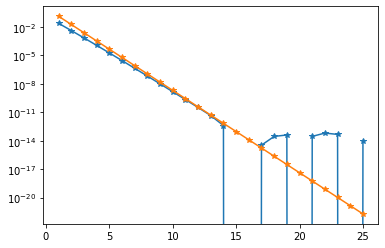

In [69]:
plt.semilogy(np.arange(1, 25+1, 1), -np.array(results), '*-')
plt.semilogy(np.arange(1, 25+1, 1), np.exp(-2*dist*np.arange(1, 25+1, 1)), '*-')

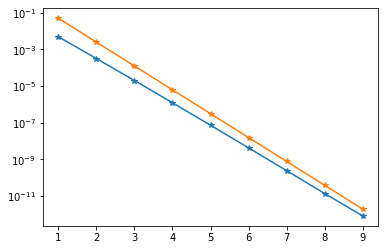

In [46]:
plt.semilogy(np.arange(1, 9+1, 1), -np.array(results[0:9]), '*-')
plt.semilogy(np.arange(1, 9+1, 1), np.exp(-2*dist*np.arange(1, 9+1, 1)), '*-')

In [140]:
N_wn = 20
lbound_wn = 0
ubound_wn = 4
quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)

In [141]:
results = []
results_kry = []
for index2, point2 in enumerate(quad_points):

    wavenumber = -1j * np.log(point2)

    slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_menger_sponge1, space_menger_sponge1, space_menger_sponge1, wavenumber)
    slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_menger_sponge2, space_menger_sponge1, space_menger_sponge1, wavenumber)
    slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_menger_sponge1, space_menger_sponge2, space_menger_sponge2, wavenumber)
    slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_menger_sponge2, space_menger_sponge2, space_menger_sponge2, wavenumber)

    mat11 = slp11.weak_form().A
    mat12 = slp12.weak_form().A
    mat21 = slp21.weak_form().A
    mat22 = slp22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

    mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
    mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

    inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                          [mat21_zero, mat22_inv]])  

    combined_inverse_free = inv_free_mat2.dot(mat)
    sign, logdet = slogdet(combined_inverse_free)

    results.append(logdet)
    
    x = np.ones(mat.shape[0]) / np.linalg.norm(np.ones(mat.shape[0]))
    rho_ = 1
    V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(mat.shape[0],1), maxiter = 50, ortho ='dmgs')
    A_m = V_m.T @ (mat - rho_*mat2) @ V_m
    B_m = V_m.T @ mat2 @ V_m
    evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
    evals_kry = evalue + rho_

    logdet_ = 0 
    for i in range(len(evals_kry)):
        logdet_ += np.log(evals_kry[i])
    results_kry.append(logdet_)
print(dist, np.trapz(-np.array(results) / quad_points, quad_points) / (2 * np.pi))
print(dist, np.trapz(-np.array(results_kry) / quad_points, quad_points) / (2 * np.pi))

0.5 0.07758612236522416
0.5 0.073054020256121


In [ ]:
0.5 0.09210733009762655
0.5 -66.9665499895402

In [10]:
for dist in np.linspace(0.5, 3, 11):
    vertices_menger_sponge2 = np.zeros((vertices_menger_sponge1.shape[0], vertices_menger_sponge1.shape[1]))
    for i in range(vertices_menger_sponge1.shape[0]):
        for j in range(vertices_menger_sponge1.shape[1]):
            if i != 1:
                vertices_menger_sponge2[i,j] = vertices_menger_sponge1[i,j]
            else:
                vertices_menger_sponge2[i,j] = vertices_menger_sponge1[i,j] + 1 + dist
    elements_menger_sponge2 = elements_menger_sponge1
    menger_sponge2 = bempp.api.Grid(vertices_menger_sponge2, elements_menger_sponge2)
    space_menger_sponge2 = bempp.api.function_space(menger_sponge2,'P',1)
    
    results = []
    for index2, point2 in enumerate(quad_points):

        wavenumber = -1j * np.log(point2)

        slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_menger_sponge1, space_menger_sponge1, space_menger_sponge1, wavenumber)
        slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_menger_sponge2, space_menger_sponge1, space_menger_sponge1, wavenumber)
        slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_menger_sponge1, space_menger_sponge2, space_menger_sponge2, wavenumber)
        slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_menger_sponge2, space_menger_sponge2, space_menger_sponge2, wavenumber)

        mat11 = slp11.weak_form().A
        mat12 = slp12.weak_form().A
        mat21 = slp21.weak_form().A
        mat22 = slp22.weak_form().A
        mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
        mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

        mat = np.block([[mat11,mat12],[mat21,mat22]])  
        mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
        mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

        inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                              [mat21_zero, mat22_inv]])  

        combined_inverse_free = inv_free_mat2.dot(mat)
        sign, logdet = slogdet(combined_inverse_free)

        results.append(logdet)
    print(dist, np.trapz(-np.array(results) / quad_points, quad_points) / (2 * np.pi))

0.5 0.08073717072783569
0.75 0.026856436806284526
1.0 0.0128775393663787
1.25 0.007280887802658512
1.5 0.004566788940828008
1.75 0.0030752755666044324
2.0 0.0021806525810865677
2.25 0.0016082889165280876
2.5 0.0012234936396223152
2.75 0.0009544222906104014
3.0 0.000760152207867592


level2
h = 0.1
0.5 0.07968272042645366
0.75 0.02667130370841872
1.0 0.012808857755347482
1.25 0.0072482972487743534
1.5 0.004548759592178762
1.75 0.003064209382760433
2.0 0.0021733384838650595
2.25 0.0016031814803548355
2.5 0.0012197731253034698
2.75 0.0009516199644726157
3.0 0.0007579836051041546

h = 0.05
0.5 0.07976488737691556
0.75 0.026688227255310514
1.0 0.01281549954110552
1.25 0.007251567097148374
1.5 0.004550614926034761
1.75 0.003065368334417256
2.0 0.002174113917925402
2.25 0.001603727634568551
2.5 0.0012201733963460551
2.75 0.0009519227544676492
3 0.0007582186589400575

level1
h = 0.1
0.5 0.08056752576888676
0.75 0.02682057644321121
1.0 0.01286335361599885
1.25 0.007273870908058812
1.5 0.004562795369976523
1.75 0.0030727759569759276
2.0 0.00217897796362143
2.25 0.0016071084598294828
2.5 0.001222628042437127
2.75 0.0009537672703161385
3.0 0.0007596436402152961